In [244]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from scipy.stats import t, shapiro, kstest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [245]:
#loading data
abundance = pd.read_csv('~/icr/simko/data/simko2_data/passport_prots.csv', index_col=0)
abundance.index = abundance.index.astype(str)
abundance

,22RV1,23132-87,42-MG-BA,451Lu,5637,639-V,647-V,697,769-P,786-0,...,WSU-NHL,YAPC,YH-13,YKG-1,YMB-1-E,YT,ZR-75-30,huH-1,no-10,no-11
protein,,,,,,,,,,,,,,,,,,,,,
A1CF,2.09,2.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,NaN,NaN
A2M,2.38,NaN,2.58,NaN,2.79,2.07,3.96,NaN,2.78,2.95,...,0.61,3.00,2.21,2.41,2.45,3.12,2.62,1.06,3.75,3.38
A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS,3.05,3.18,2.69,4.21,4.07,3.21,3.76,3.15,3.44,2.55,...,3.46,2.87,3.72,3.36,NaN,2.97,3.22,3.75,3.74,3.02
AACS,2.37,1.42,2.50,3.49,NaN,1.96,NaN,NaN,2.08,NaN,...,NaN,NaN,1.70,NaN,3.44,3.70,2.00,-1.34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWILCH,2.38,2.08,1.61,NaN,NaN,2.88,NaN,2.68,2.77,1.70,...,1.84,1.02,1.63,3.00,NaN,2.08,NaN,NaN,NaN,3.48
ZWINT,1.69,1.85,1.74,NaN,NaN,2.11,NaN,2.27,2.20,1.82,...,2.00,NaN,1.97,2.98,NaN,1.96,1.18,NaN,1.63,2.71
ZYX,3.60,4.74,5.95,4.34,1.40,6.03,2.50,3.24,7.01,6.61,...,4.78,2.44,7.71,5.62,3.90,6.10,4.56,3.59,6.23,6.07


In [246]:
#doing the cell line nan check
nans_per_cl = abundance.isna().sum(axis=0)
nans_per_cl = nans_per_cl.sort_values(ascending=False)

#assigning pathways to cell lines
tissue_lists = pd.read_csv('~/icr/simko/data/simko2_data/model_list_20240110.csv', index_col=0)
cl_groups = pd.DataFrame({'model_name':abundance.columns})
cl_groups = cl_groups.merge(tissue_lists[['model_name', 'tissue']])

#merging the tissue and nan info togtehr for each cell line
nans_per_cl_dataframe = nans_per_cl.reset_index()
nans_per_cl_dataframe.columns = ['model_name', 'num_nans']

cl_info = cl_groups.merge(nans_per_cl_dataframe, on='model_name')
cl_info

,model_name,tissue,num_nans
0,22RV1,Prostate,3008
1,23132-87,Stomach,3191
2,42-MG-BA,Central Nervous System,3283
3,451Lu,Skin,3562
4,5637,Bladder,4571
...,...,...,...
945,YT,Haematopoietic and Lymphoid,3144
946,ZR-75-30,Breast,3148
947,huH-1,Liver,3915
948,no-10,Central Nervous System,2989


<Axes: >

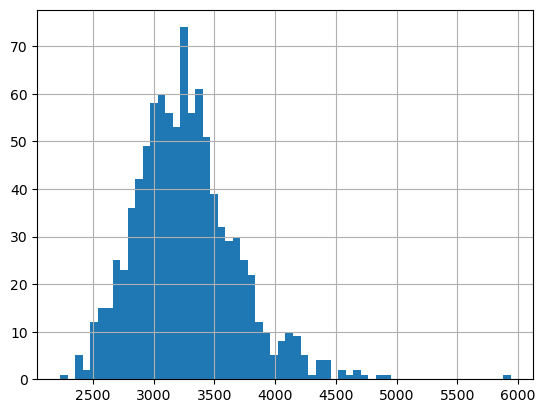

In [247]:
nans_per_cl.hist(bins=60)

In [248]:
#getting ride of cell lines with over 4200 nans
abundance_cl_filtered = abundance.loc[:, nans_per_cl<4000]
abundance_cl_filtered

,22RV1,23132-87,42-MG-BA,451Lu,639-V,697,769-P,786-0,8-MG-BA,8305C,...,WSU-NHL,YAPC,YH-13,YKG-1,YMB-1-E,YT,ZR-75-30,huH-1,no-10,no-11
protein,,,,,,,,,,,,,,,,,,,,,
A1CF,2.09,2.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,NaN,NaN
A2M,2.38,NaN,2.58,NaN,2.07,NaN,2.78,2.95,NaN,2.58,...,0.61,3.00,2.21,2.41,2.45,3.12,2.62,1.06,3.75,3.38
A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,1.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS,3.05,3.18,2.69,4.21,3.21,3.15,3.44,2.55,3.92,3.25,...,3.46,2.87,3.72,3.36,NaN,2.97,3.22,3.75,3.74,3.02
AACS,2.37,1.42,2.50,3.49,1.96,NaN,2.08,NaN,NaN,NaN,...,NaN,NaN,1.70,NaN,3.44,3.70,2.00,-1.34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWILCH,2.38,2.08,1.61,NaN,2.88,2.68,2.77,1.70,-0.39,NaN,...,1.84,1.02,1.63,3.00,NaN,2.08,NaN,NaN,NaN,3.48
ZWINT,1.69,1.85,1.74,NaN,2.11,2.27,2.20,1.82,2.24,3.07,...,2.00,NaN,1.97,2.98,NaN,1.96,1.18,NaN,1.63,2.71
ZYX,3.60,4.74,5.95,4.34,6.03,3.24,7.01,6.61,5.03,5.04,...,4.78,2.44,7.71,5.62,3.90,6.10,4.56,3.59,6.23,6.07


In [249]:
#getting rid of protein with over 80% NaN (from the dataset filtered by CLs)
prot_nan_count = abundance_cl_filtered.isna().sum(axis=1)
prot_nan_percent = (prot_nan_count/abundance_cl_filtered.shape[1])*100

abundance_filtered = abundance_cl_filtered[prot_nan_percent<80]
abundance_filtered

,22RV1,23132-87,42-MG-BA,451Lu,639-V,697,769-P,786-0,8-MG-BA,8305C,...,WSU-NHL,YAPC,YH-13,YKG-1,YMB-1-E,YT,ZR-75-30,huH-1,no-10,no-11
protein,,,,,,,,,,,,,,,,,,,,,
A2M,2.38,NaN,2.58,NaN,2.07,NaN,2.78,2.95,NaN,2.58,...,0.61,3.00,2.21,2.41,2.45,3.12,2.62,1.06,3.75,3.38
AAAS,3.05,3.18,2.69,4.21,3.21,3.15,3.44,2.55,3.92,3.25,...,3.46,2.87,3.72,3.36,NaN,2.97,3.22,3.75,3.74,3.02
AACS,2.37,1.42,2.50,3.49,1.96,NaN,2.08,NaN,NaN,NaN,...,NaN,NaN,1.70,NaN,3.44,3.70,2.00,-1.34,NaN,NaN
AAGAB,3.23,3.49,3.32,NaN,3.44,3.16,3.06,3.06,2.87,NaN,...,4.09,3.27,3.32,3.05,4.12,4.48,3.53,2.29,2.75,2.85
AAK1,2.99,1.80,2.59,2.02,3.52,3.45,3.85,3.78,2.76,2.96,...,NaN,NaN,3.70,2.80,3.63,2.98,3.14,2.42,3.58,3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW10,2.32,1.55,1.84,2.12,2.64,2.70,1.13,2.62,2.50,3.44,...,2.73,2.32,3.48,2.57,3.17,2.51,2.35,1.98,3.11,3.11
ZWILCH,2.38,2.08,1.61,NaN,2.88,2.68,2.77,1.70,-0.39,NaN,...,1.84,1.02,1.63,3.00,NaN,2.08,NaN,NaN,NaN,3.48
ZWINT,1.69,1.85,1.74,NaN,2.11,2.27,2.20,1.82,2.24,3.07,...,2.00,NaN,1.97,2.98,NaN,1.96,1.18,NaN,1.63,2.71


In [250]:
#checking if the proteins we are interested in the filtered data set
# list of proteins
proteins_of_interest = pd.read_csv('~/icr/simko/data/proteins_of_interest.csv')
proteins_of_interest_list = list(proteins_of_interest['Gene'])



In [251]:
#all proteins in the abundance data set after CL removal (same as befor removal)
all_prots = list(abundance_cl_filtered.index)
len(all_prots)

8457

In [252]:
#proteins in the filtered abundance dataset (80% nan threshold)
filtered_prots = list(abundance_filtered.index)
len(filtered_prots)

6892

In [253]:
#for loop: checking if proteins of interest are in the orginal data abundance data set
proteins_of_interest_in_og_df = []

for protein in proteins_of_interest_list:
    if protein in all_prots:
        proteins_of_interest_in_og_df.append(protein)
       

print(proteins_of_interest_in_og_df)
len(proteins_of_interest_in_og_df)

['PTPN1', 'BRCA2', 'BRCA1', 'UBE2T', 'FANCD2', 'PCNA', 'CHEK1', 'BLM', 'USP1', 'FANCA', 'WDR48', 'CCNH', 'CDK2', 'RPA2', 'ERCC1', 'GTF2H1', 'MNAT1', 'GTF2E1', 'ERCC2', 'GTF2E2', 'ERCC3', 'POLR2A', 'GTF2H5', 'XAB2', 'CDKN1B', 'CDKN1A', 'CDK4', 'CCND3', 'CCND1', 'CDK6', 'CDK1', 'CDK11B', 'MCM2', 'TP53', 'ETS1', 'POU5F1', 'AR', 'INIP', 'INTS3', 'CDK7', 'POLR2D', 'POLR2C', 'GTF2F2', 'POLR2F', 'POLR2B', 'POLR2K', 'POLR2E', 'GTF2B', 'POLR2G', 'GTF2F1', 'POLR2I', 'GTF2A2', 'POLR2L', 'GTF2A1', 'ABL1', 'DAXX', 'RMI2', 'RAD50', 'WRN', 'TOP3A', 'MRE11', 'NBN', 'EXO1', 'RMI1', 'TOPBP1', 'RPA1', 'MSH2', 'FANCI', 'SFPQ', 'UBE2I', 'BARD1', 'STAT5A', 'E2F4', 'RECQL5', 'RAD51AP1', 'CASP3', 'CAV1', 'CAT', 'GNAS', 'RPS4Y1', 'NDUFA4', 'CDK5', 'RAD18', 'MLH1', 'IGFBP2', 'GSDMD', 'RBX1', 'POLD1', 'CUL4B', 'CUL4A', 'CRBN', 'POLD3', 'POLD2', 'UBE2M', 'CCDC22', 'DCAF6', 'RPA3', 'DDA1', 'DTL', 'DDB2', 'GPS1', 'COMMD1', 'CAND1', 'COPS5', 'XRCC4', 'LIG4', 'XRCC6', 'XRCC5', 'PARP1', 'APEX1', 'PPM1D', 'NEU1', 'SPP1

1156

In [254]:
#from these 1156 proteins of interest which are definitely in the og abundance data - how which ones ARE NOT in the filtered (>80% Nan) abundance data
proteins_not_in_filt_df = []

for protein in proteins_of_interest_in_og_df:
    if protein not in filtered_prots:
        proteins_not_in_filt_df.append(protein)

print(proteins_not_in_filt_df)
len(proteins_not_in_filt_df)

['USP1', 'CDKN1B', 'CDKN1A', 'CCND3', 'CCND1', 'POU5F1', 'AR', 'EXO1', 'RMI1', 'STAT5A', 'DTL', 'COMMD1', 'SPP1', 'MT1X', 'ALKBH1', 'UBR2', 'CREBBP', 'TF', 'FAM111B', 'OLFML3', 'CDC6', 'YBX2', 'SUMO3', 'RIPOR2', 'CTSV', 'HERC5', 'PDE5A', 'CRYM', 'TATDN3', 'CDC45', 'TP63', 'SMAD1', 'PPP1R1B', 'MT1F', 'ACTN3', 'PLTP', 'ZMIZ1', 'EAPP', 'TANGO6', 'WDR6', 'FOXP4', 'APTX', 'VHL', 'KIT', 'KITLG', 'TP73', 'EBF2', 'MAD2L2', 'RINT1', 'CDKN1C', 'AHR', 'NKX3-1', 'MYCN', 'PDGFRB', 'NFYA', 'CKM', 'MMP2', 'MMP9', 'ATF3', 'FGFR1', 'HNF4A', 'S100B', 'HIC1', 'AFP', 'RCHY1', 'SMG1', 'PTGS2', 'PCSK9', 'GPCPD1', 'VAT1L', 'ARHGEF39', 'CADPS', 'TTYH1', 'GDF3', 'DDX43', 'GNA14', 'CEP78', 'CRLF1', 'CYP19A1', 'LMO4', 'CLK2', 'GZMA', 'RELB', 'PIAS4', 'ESPN', 'GNG7', 'HVCN1', 'PUS7L', 'NEBL', 'TRIAP1', 'KIAA1191', 'LZTS3', 'PRSS1', 'DCAF11', 'DOP1B', 'MELK', 'PMEL', 'PAX2', 'FAM76A', 'LIN28A', 'KLC3', 'PTPRZ1', 'SH3GL3', 'ZNF121', 'SP4', 'NCR2', 'TXNL4B', 'ZNHIT6', 'DPPA4', 'H1-2', 'GPR50', 'ARHGEF18', 'ACBD7', '

117

In [255]:
#set the protein names as the index - ignores it while we find the lower quartile
# abundance_filtered.set_index('protein', inplace=True)

def average_lower_quartile(x):
    sorted_abundances = x.dropna().sort_values()
    lower_qt_values = sorted_abundances.iloc[:int(len(sorted_abundances) * 0.25)]
    return lower_qt_values.mean()

lower_qt_averages = abundance_filtered.apply(average_lower_quartile, axis=1)

abundance_filtered_no_nan = abundance_filtered.apply(lambda x: x.fillna(lower_qt_averages[x.name]), axis=1)


In [256]:

lower_qt_averages


protein
A2M       1.070559
AAAS      2.657713
AACS      1.015342
AAGAB     2.313763
AAK1      1.688155
            ...   
ZW10      1.838739
ZWILCH    0.970779
ZWINT     0.848075
ZYX       2.336056
ZZZ3     -0.302169
Length: 6892, dtype: float64

In [257]:

abundance_filtered_no_nan

,22RV1,23132-87,42-MG-BA,451Lu,639-V,697,769-P,786-0,8-MG-BA,8305C,...,WSU-NHL,YAPC,YH-13,YKG-1,YMB-1-E,YT,ZR-75-30,huH-1,no-10,no-11
protein,,,,,,,,,,,,,,,,,,,,,
A2M,2.38,1.070559,2.580000,1.070559,2.070000,1.070559,2.780000,2.950000,1.070559,2.580000,...,0.610000,3.000000,2.21,2.410000,2.450000,3.120000,2.620000,1.060000,3.750000,3.380000
AAAS,3.05,3.180000,2.690000,4.210000,3.210000,3.150000,3.440000,2.550000,3.920000,3.250000,...,3.460000,2.870000,3.72,3.360000,2.657713,2.970000,3.220000,3.750000,3.740000,3.020000
AACS,2.37,1.420000,2.500000,3.490000,1.960000,1.015342,2.080000,1.015342,1.015342,1.015342,...,1.015342,1.015342,1.70,1.015342,3.440000,3.700000,2.000000,-1.340000,1.015342,1.015342
AAGAB,3.23,3.490000,3.320000,2.313763,3.440000,3.160000,3.060000,3.060000,2.870000,2.313763,...,4.090000,3.270000,3.32,3.050000,4.120000,4.480000,3.530000,2.290000,2.750000,2.850000
AAK1,2.99,1.800000,2.590000,2.020000,3.520000,3.450000,3.850000,3.780000,2.760000,2.960000,...,1.688155,1.688155,3.70,2.800000,3.630000,2.980000,3.140000,2.420000,3.580000,3.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW10,2.32,1.550000,1.840000,2.120000,2.640000,2.700000,1.130000,2.620000,2.500000,3.440000,...,2.730000,2.320000,3.48,2.570000,3.170000,2.510000,2.350000,1.980000,3.110000,3.110000
ZWILCH,2.38,2.080000,1.610000,0.970779,2.880000,2.680000,2.770000,1.700000,-0.390000,0.970779,...,1.840000,1.020000,1.63,3.000000,0.970779,2.080000,0.970779,0.970779,0.970779,3.480000
ZWINT,1.69,1.850000,1.740000,0.848075,2.110000,2.270000,2.200000,1.820000,2.240000,3.070000,...,2.000000,0.848075,1.97,2.980000,0.848075,1.960000,1.180000,0.848075,1.630000,2.710000


In [258]:
#trasnposing
abundance_imputed = abundance_filtered_no_nan.T
abundance_imputed

protein,A2M,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS1,AARS2,...,ZNRF1,ZNRF2,ZPR1,ZRANB2,ZSWIM8,ZW10,ZWILCH,ZWINT,ZYX,ZZZ3
22RV1,2.380000,3.05,2.370000,3.230000,2.99,0.773861,2.67,-0.322075,6.43,3.81,...,-0.881522,1.593953,3.78,4.54,4.850000,2.32,2.380000,1.690000,3.60,0.430000
23132-87,1.070559,3.18,1.420000,3.490000,1.80,0.820000,3.01,-0.322075,6.05,3.37,...,-0.881522,1.920000,3.56,3.60,3.740000,1.55,2.080000,1.850000,4.74,-0.302169
42-MG-BA,2.580000,2.69,2.500000,3.320000,2.59,1.630000,2.76,2.070000,5.85,2.80,...,-0.881522,2.280000,4.70,4.24,3.226549,1.84,1.610000,1.740000,5.95,-0.302169
451Lu,1.070559,4.21,3.490000,2.313763,2.02,2.410000,3.49,-0.322075,5.53,4.18,...,-0.881522,2.180000,2.47,4.50,4.240000,2.12,0.970779,0.848075,4.34,2.330000
639-V,2.070000,3.21,1.960000,3.440000,3.52,3.210000,2.96,-0.322075,5.81,3.83,...,-0.881522,1.750000,4.30,4.52,4.330000,2.64,2.880000,2.110000,6.03,-0.302169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,3.120000,2.97,3.700000,4.480000,2.98,2.280000,3.30,1.360000,5.91,3.46,...,2.250000,3.940000,4.91,4.92,5.090000,2.51,2.080000,1.960000,6.10,-0.302169
ZR-75-30,2.620000,3.22,2.000000,3.530000,3.14,0.773861,0.97,-0.322075,4.22,3.67,...,-0.881522,3.360000,1.50,3.49,4.300000,2.35,0.970779,1.180000,4.56,-0.302169
huH-1,1.060000,3.75,-1.340000,2.290000,2.42,0.773861,2.22,-0.322075,4.46,3.37,...,-0.881522,1.720000,2.64,3.31,3.700000,1.98,0.970779,0.848075,3.59,-0.302169
no-10,3.750000,3.74,1.015342,2.750000,3.58,2.940000,2.21,-0.322075,6.73,3.15,...,1.320000,2.960000,4.74,5.71,4.700000,3.11,0.970779,1.630000,6.23,2.030000


In [259]:
#scaling the imputed data
scaler = StandardScaler()

abundance_scaled = pd.DataFrame(scaler.fit_transform(abundance_imputed), index=abundance_imputed.index, columns=abundance_imputed.columns)

abundance_scaled

protein,A2M,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS1,AARS2,...,ZNRF1,ZNRF2,ZPR1,ZRANB2,ZSWIM8,ZW10,ZWILCH,ZWINT,ZYX,ZZZ3
22RV1,0.342722,-0.599504,0.701731,0.373205,0.273465,-0.888683,-0.059871,-0.429056,0.729819,0.345549,...,-0.400057,-0.957210,0.219998,0.372528,1.369224,-0.386513,0.846034,-0.013109,-0.480591,0.215376
23132-87,-0.819957,-0.374452,-0.380941,0.778324,-1.073026,-0.845326,0.368493,-0.429056,0.371404,-0.310498,...,-0.400057,-0.612362,0.023232,-0.982772,-0.142116,-1.861737,0.482725,0.158125,0.214974,-0.548804
42-MG-BA,0.520306,-1.222724,0.849886,0.513439,-0.179137,-0.084156,0.053520,2.528890,0.182765,-1.160377,...,-0.400057,-0.231603,1.042839,-0.060015,-0.841214,-1.306133,-0.086458,0.040402,0.953249,-0.548804
451Lu,-0.819957,1.408649,1.978143,-1.054430,-0.824095,0.648821,0.973242,-0.429056,-0.119057,0.897225,...,-0.400057,-0.337369,-0.951656,0.314856,0.538668,-0.769688,-0.860572,-0.914145,-0.029084,2.198447
639-V,0.067467,-0.322517,0.234473,0.700417,0.873162,1.400594,0.305498,-0.429056,0.145037,0.375369,...,-0.400057,-0.792165,0.685082,0.343692,0.661209,0.226567,1.451548,0.436379,1.002060,-0.548804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0.999783,-0.737997,2.217471,2.320894,0.262149,0.526658,0.733862,1.650932,0.239357,-0.176307,...,3.087972,1.524120,1.230662,0.920416,1.696000,-0.022497,0.482725,0.275848,1.044771,-0.548804
ZR-75-30,0.555823,-0.305206,0.280059,0.840650,0.443190,-0.888683,-2.201689,-0.429056,-1.354644,0.136807,...,-0.400057,0.910675,-1.819217,-1.141371,0.620362,-0.329037,-0.860572,-0.558915,0.105148,-0.548804
huH-1,-0.829333,0.612312,-3.526386,-1.091457,-0.371493,-0.888683,-0.626822,-0.429056,-1.128277,-0.310498,...,-0.400057,-0.823895,-0.799609,-1.400897,-0.196579,-1.037911,-0.860572,-0.914145,-0.486693,-0.548804
no-10,1.559173,0.595001,-0.842110,-0.374708,0.941052,1.146870,-0.639421,-0.429056,1.012777,-0.638522,...,2.052096,0.487609,1.078615,2.059445,1.164989,1.127028,-0.860572,-0.077321,1.124089,1.885331


In [279]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # Number of proteins
        self.latent_dim = latent_dim  # Size of latent space

        # Encoder: Maps input -> (mu, log_var)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        #latent mean and variance
        self.fc_mu = nn.Linear(latent_dim, 50)  # Mean (mu)
        self.fc_log_var = nn.Linear(latent_dim, 50)  # Log variance (log_var)

        # Decoder: Maps latent space -> reconstructed protein abundances
        self.decoder = nn.Sequential(
            nn.Linear(50, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2048), 
            nn.ReLU(),
            nn.Linear(2048, input_dim) # Output same shape as input
        )
    
    def encode(self, x):
        """Encodes input into latent space parameters (mu and log_var)."""
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var


    def reparameterize(self, mu, log_var):
        """Reparameterization trick: Sample z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal
        return mu + eps * std  # Sampled latent vector
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        """Full forward pass: Encode -> Reparameterize -> Decode."""
        mu, log_var = self.encode(x)  # Encode input
        z = self.reparameterize(mu, log_var)  # Reparameterize
        x_recon = self.decode(z)  # Decode back to original space
        return x_recon, mu, log_var

In [280]:
#defining loss function - we're trying to find the best weights so that we have good reconstructed output and good regulariosed latent space
def vae_loss(x, x_recon, mu, log_var, recon_weight=0.01, kl_weight=1.0):
    # Reconstruction loss (Mean Squared Error)
    recon_loss = nn.MSELoss()(x_recon, x)

    # KL Divergence Loss (Regularizes latent space)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss = Reconstruction + KL divergence
    return (recon_loss * recon_weight) + (kl_loss * kl_weight)  # Small weight for KL term


In [281]:

#coverting scaled data to a tensor
X = abundance_scaled
X_tensor = torch.tensor(X.values, dtype=torch.float32)
batch_size = 32
dataset = Data.TensorDataset(X_tensor)
dataloader = Data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [282]:
input_dim = X.shape[1]
latent_dim = 128
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [284]:
#defining a function to train the model and tracvk the loss for different weights
def train_with_loss_weights(recon_weight, kl_weight):
    vae = VAE(input_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    
    num_epochs = 15
    total_loss = 0
    
    for epoch in range(num_epochs):
        for batch in dataloader:
            x_batch = batch[0]

            # Forward pass
            x_recon, mu, log_var = vae(x_batch)
            
            # Compute loss with specified weights
            loss = vae_loss(x_batch, x_recon, mu, log_var, recon_weight, kl_weight)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

    # Return the final loss value for this combination of weights
    return total_loss / len(dataloader)

In [285]:
#then creatign a range of values for the loss weights and trying combinations
# Range of values for the loss weights
recon_weights = [0.001, 0.01, 0.1, 1.0, 10.0]
kl_weights = [0.001, 0.01, 0.1, 1.0, 10.0]

# Try all combinations of weights
best_loss = float('inf')
best_recon_weight = None
best_kl_weight = None

In [266]:
#for loop finding the best combination of weights
for recon_weight in recon_weights:
    for kl_weight in kl_weights:
        print(f"Training with recon_weight={recon_weight}, kl_weight={kl_weight}...")
        
        # Train the VAE with the current weights and get the total loss
        loss = train_with_loss_weights(recon_weight, kl_weight)
        
        # Track the best weight combination
        if loss < best_loss:
            best_loss = loss
            best_recon_weight = recon_weight
            best_kl_weight = kl_weight

        print(f"Loss for recon_weight={recon_weight}, kl_weight={kl_weight}: {loss:.4f}")

Training with recon_weight=0.001, kl_weight=0.001...
Loss for recon_weight=0.001, kl_weight=0.001: 0.0311
Training with recon_weight=0.001, kl_weight=0.01...
Loss for recon_weight=0.001, kl_weight=0.01: 0.2085
Training with recon_weight=0.001, kl_weight=0.1...
Loss for recon_weight=0.001, kl_weight=0.1: 2.0451
Training with recon_weight=0.001, kl_weight=1.0...
Loss for recon_weight=0.001, kl_weight=1.0: 25.0653
Training with recon_weight=0.001, kl_weight=10.0...
Loss for recon_weight=0.001, kl_weight=10.0: 165.0178
Training with recon_weight=0.01, kl_weight=0.001...
Loss for recon_weight=0.01, kl_weight=0.001: 0.1648
Training with recon_weight=0.01, kl_weight=0.01...
Loss for recon_weight=0.01, kl_weight=0.01: 0.2788
Training with recon_weight=0.01, kl_weight=0.1...
Loss for recon_weight=0.01, kl_weight=0.1: 1.2288
Training with recon_weight=0.01, kl_weight=1.0...
Loss for recon_weight=0.01, kl_weight=1.0: 18.0794
Training with recon_weight=0.01, kl_weight=10.0...
Loss for recon_weight

In [267]:
# Output the best weights
print(f"Best recon_weight: {best_recon_weight}, Best kl_weight: {best_kl_weight}, Best Loss: {best_loss:.4f}")

Best recon_weight: 0.001, Best kl_weight: 0.001, Best Loss: 0.0311


In [286]:
#now training again with the specified weights we just found
#defining loss function - we're trying to find the best weights so that we have good reconstructed output and good regulariosed latent space
def vae_loss(x, x_recon, mu, log_var, recon_weight=0.001, kl_weight=0.001):
    # Reconstruction loss (Mean Squared Error)
    recon_loss = nn.MSELoss()(x_recon, x)

    # KL Divergence Loss (Regularizes latent space)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss = Reconstruction + KL divergence
    return (recon_loss * recon_weight)  + (kl_loss * kl_weight)  # Small weight for KL term

In [287]:
#training the vae - trying to find best hyperparameters for weights in kl_divergebce and reconstructed (MSE) loss
num_epochs = 15
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]

        # Forward pass
        x_recon, mu, log_var = vae(x_batch)
        
        # Compute loss
        loss = vae_loss(x_batch, x_recon, mu, log_var)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")


Epoch 1, Loss: 0.0145
Epoch 2, Loss: 0.0019
Epoch 3, Loss: 0.0011
Epoch 4, Loss: 0.0010
Epoch 5, Loss: 0.0010
Epoch 6, Loss: 0.0010


KeyboardInterrupt: 

In [276]:
x_recon

tensor([[-0.0005, -0.0001,  0.0005,  ..., -0.0002,  0.0034, -0.0040],
        [ 0.0024, -0.0131, -0.0058,  ...,  0.0055,  0.0044, -0.0013],
        [ 0.0033, -0.0035, -0.0043,  ...,  0.0027,  0.0039, -0.0030],
        ...,
        [-0.0024, -0.0049,  0.0010,  ...,  0.0034,  0.0086, -0.0031],
        [ 0.0003, -0.0009, -0.0074,  ...,  0.0040,  0.0085, -0.0081],
        [ 0.0029, -0.0071, -0.0046,  ..., -0.0027,  0.0017, -0.0107]],
       grad_fn=<AddmmBackward0>)

In [168]:
#simulating the knockout
def simulate_knockout(vae, x, knockout_indices):
    """
    Given a batch of input data 'x' and a list of protein indices to knock out,
    this function creates a perturbed version of the data by zeroing out the specified proteins,
    then passes the perturbed data through the encoder and decoder to obtain a synthetic profile.
    """
    vae.eval()
    with torch.no_grad():
        # Create a perturbed copy of the input data
        x_perturbed = x.clone()
        x_perturbed[:, knockout_indices] = 0.01  # Set selected protein abundances to zero

        recon, _, _ = vae(x_perturbed)
    return recon

In [169]:
#finding the index of pbrm1
pbrm1_index = list(abundance_scaled.columns).index('PBRM1')
pbrm1_index

4175

In [170]:
# Example usage: simulate a knockout for proteins at indices 10 and 20
knockout_indices = [pbrm1_index]

# Select a few samples from the dataset (for example, the first 5 samples)

x_knockout = simulate_knockout(vae=vae, x=X_tensor, knockout_indices=knockout_indices)

# Display the original and synthetic (post-knockout) profiles for the first sample
print("Original protein profile (first sample):")
print(X_tensor[0])
print("\nSynthetic protein profile after knockout (first sample):")
print(x_knockout[0])

Original protein profile (first sample):
tensor([ 0.3427, -0.5995,  0.7017,  ..., -0.0131, -0.4806,  0.2154])

Synthetic protein profile after knockout (first sample):
tensor([ 0.0003, -0.0106, -0.0073,  ...,  0.0036, -0.0028,  0.0004])


In [171]:
X_tensor

tensor([[ 0.3427, -0.5995,  0.7017,  ..., -0.0131, -0.4806,  0.2154],
        [-0.8200, -0.3745, -0.3809,  ...,  0.1581,  0.2150, -0.5488],
        [ 0.5203, -1.2227,  0.8499,  ...,  0.0404,  0.9532, -0.5488],
        ...,
        [-0.8293,  0.6123, -3.5264,  ..., -0.9141, -0.4867, -0.5488],
        [ 1.5592,  0.5950, -0.8421,  ..., -0.0773,  1.1241,  1.8853],
        [ 1.2306, -0.6514, -0.8421,  ...,  1.0785,  1.0265, -0.5488]])

In [172]:
x_knockout

tensor([[ 2.8694e-04, -1.0565e-02, -7.2942e-03,  ...,  3.5622e-03,
         -2.8013e-03,  4.2609e-04],
        [ 3.6451e-03, -1.1496e-02, -1.5739e-03,  ..., -1.5107e-03,
         -5.5458e-03,  2.5230e-03],
        [ 1.2337e-03, -7.4513e-03, -1.6441e-03,  ...,  5.1591e-05,
         -3.1693e-03,  1.7167e-03],
        ...,
        [ 8.6863e-03,  2.0803e-03, -8.0241e-04,  ...,  4.1438e-05,
         -1.6349e-02, -6.3299e-03],
        [-6.0688e-03, -2.9746e-03,  3.1416e-03,  ...,  3.0103e-03,
         -6.6223e-03, -6.3933e-03],
        [ 2.2009e-03, -8.3144e-03, -4.1716e-03,  ..., -3.7916e-03,
         -3.4977e-03,  2.0034e-03]])

In [173]:
# Compute absolute difference between original and knockout data
protein_changes = torch.abs(x_knockout - X_tensor)

# Get the mean change across all samples for each protein
mean_changes = protein_changes.mean(dim=0)

# Convert to a Pandas DataFrame for easy visualization
protein_change_df = pd.DataFrame({
    'Protein': abundance_scaled.columns, 
    'Mean Change': mean_changes.numpy()
})

# Sort proteins by the amount of change (descending order)
protein_change_df = protein_change_df.sort_values(by='Mean Change', ascending=False)

# Display top 10 most affected proteins
print(protein_change_df.head(50))


        Protein  Mean Change
3134  LRRC37A5P     0.941077
2088     FGFRL1     0.941036
823      CAVIN1     0.912564
2152       FRYL     0.910481
2982      KRT19     0.910434
6488      UCHL1     0.903973
821        CAV1     0.901108
3722     NBEAL1     0.900001
1012     CEP290     0.897646
2991       KRT7     0.896787
3219     MANSC1     0.895832
2981      KRT18     0.895332
2816      ITGA3     0.894875
3195       MAFA     0.893734
1319      CRIP2     0.893540
945        CDH1     0.892460
2863        JUP     0.891345
1634      DNHD1     0.889756
2489      HAUS4     0.889532
2998       KRT8     0.887128
6498      UFSP2     0.886908
6602        VIM     0.886648
6012      TDRD5     0.885448
6319        TRO     0.884955
2559      HLA-F     0.883688
1007     CEP104     0.883660
3160        LSR     0.883346
1219     COL1A1     0.882500
2431      GSTZ1     0.882146
876      CCDC97     0.882029
2382     GPR107     0.882015
3017       LAD1     0.881653
3647       MYH1     0.881613
3034    LAMTOR

In [174]:
#reconstruct og data set
vae.eval()

with torch.no_grad():
    X_recon, _,_ = vae(X_tensor)

In [175]:
X_recon

tensor([[ 4.7293e-05, -1.5425e-02, -4.0496e-03,  ...,  4.2445e-03,
         -1.1014e-02,  1.1733e-03],
        [-2.5066e-03, -8.0949e-03, -9.7309e-03,  ...,  6.5087e-03,
         -8.5170e-03, -1.3225e-03],
        [ 5.4367e-04, -8.1999e-03, -7.6973e-03,  ..., -1.0432e-03,
         -6.1100e-03,  6.2280e-03],
        ...,
        [-2.2739e-04, -1.3885e-02, -3.7391e-03,  ...,  3.0714e-03,
         -8.7519e-05, -6.1935e-04],
        [ 1.9209e-03, -9.1610e-03, -4.5285e-03,  ..., -7.9042e-04,
         -3.0897e-03,  1.2609e-03],
        [-4.1058e-03, -1.0161e-03, -9.2952e-03,  ...,  5.9759e-03,
         -1.1112e-02, -4.0987e-03]])

In [177]:
#looking at a specific protein we know id affected by pbrm1 KO - seeing its distribution across 
# Compute absolute difference between original and knockout data
protein_changes = torch.abs(x_knockout - X_recon)

# Get the mean change across all samples for each protein
mean_changes = protein_changes.mean(dim=0)

# Convert to a Pandas DataFrame for easy visualization
protein_change_df = pd.DataFrame({
    'Protein': abundance_scaled.columns, 
    'Mean Change': mean_changes.numpy()
})

# Sort proteins by the amount of change (descending order)
protein_change_df = protein_change_df.sort_values(by='Mean Change', ascending=False)

# Display top 10 most affected proteins
print(protein_change_df.tail(50))

       Protein  Mean Change
559        BAD     0.002495
3502    MRPL22     0.002489
3230    MAP2K6     0.002487
900      CD151     0.002477
2552       HK2     0.002475
691       BZW2     0.002470
1544      DGKA     0.002469
2911  KIAA1671     0.002467
6844    ZNF292     0.002466
775     CAMKK2     0.002462
1143      CLPP     0.002459
3081     LIMD1     0.002456
3406     MINK1     0.002454
3774   NDUFAF1     0.002447
323       APC2     0.002443
5805     STAT2     0.002443
6744      YBX3     0.002441
6648      WAPL     0.002439
3862      NIFK     0.002438
2807     ISOC2     0.002436
4716     PSME3     0.002431
4726     PSRC1     0.002430
3083     LIMS1     0.002429
6085    TIMM8A     0.002425
2516    HEATR1     0.002424
2709   IGFBPL1     0.002418
1422    CYFIP1     0.002412
1882     EPHA2     0.002412
5089     RNPS1     0.002408
6242      TPM3     0.002405
2590   HNRNPAB     0.002404
2474      H6PD     0.002400
6174     TMOD2     0.002397
6346      TSR2     0.002393
4898      RALY     0